### Stack Overflow: Tag Prediction (DATA : KAGGLE COMPETITION)

**Description**:
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.

Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.

### Problem Statemtent:
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

### Real World / Business Objectives and Constraints:
1) Predict as many tags as possible with high precision and recall.
2) Incorrect tags could impact customer experience on StackOverflow.
3) No strict latency constraints.

### Type of Machine Learning Problem 
1) It is a multi-label classification problem.

2) Multi-label Classification: Multilabel classification assigns to each sample a set of target      labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. 

3) Credit: http://scikit-learn.org/stable/modules/multiclass.html

### Performance metric 
Micro-Averaged F1-Score (Mean F Score) : The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 (precision recall) / (precision + recall)

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. 

**'Micro f1 score'**: 
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance. 

**'Macro f1 score'**: 
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. 

In [1]:
#Importing the libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [2]:
#Importing the dataset
dataset= pd.read_csv('Train_1.csv', names=['Id', 'Title', 'Body', 'Tags'],iterator=False, encoding='utf-8')

In [3]:
# Counting the Number of rows
shape=dataset.shape
print("The shape of the data is :",shape)

The shape of the data is : (6034196, 4)


In [4]:
dataset.head(3)

,Id,Title,Body,Tags
0,Id,Title,Body,Tags
1,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
2,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox


In [5]:
#Dropping the duplicates
dataset_1=dataset.drop_duplicates(subset={'Title','Body','Tags'},keep='first',inplace=False)

In [6]:
#Shape of reduced dataset
dataset_1.shape

(4206315, 4)

In [7]:
#Counting Number of Tags per Question
dataset_1['Tag_Count']=dataset_1['Tags'].apply(lambda tags :len(tags.split(" ")))
dataset_1.head(3)

,Id,Title,Body,Tags,Tag_Count
0,Id,Title,Body,Tags,1
1,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
2,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1


In [8]:
# Distribution of number of tags per question
dataset_1.Tag_Count.value_counts()

3    1206157
2    1111706
4     814996
1     568298
5     505158
Name: Tag_Count, dtype: int64

In [9]:
#Dropping the unwanted Column in the data
dataset_2=dataset_1.drop(['Id'],axis=1)
dataset_2.head()

,Title,Body,Tags,Tag_Count
0,Title,Body,Tags,1
1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3


### Analysis of Tags

In [10]:
# Total Number of Unique Tags (BOW Method)
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(" "))
tag_dtm = vectorizer.fit_transform(dataset_2['Tags'])

In [11]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])  

Number of data points : 4206315
Number of unique tags : 42048


In [12]:
# few tags name
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [13]:
#Number of times a tag appeared
frequency_tags= tag_dtm.sum(axis=0).A1
result=dict(zip(tags,frequency_tags))

In [14]:
#Saving dictionary to csv file
import csv
with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in result.items():
       writer.writerow([key, value])

In [15]:
# Each Tag Occurences
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [18]:
# Sorting tags in descending (decreasing order) order
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

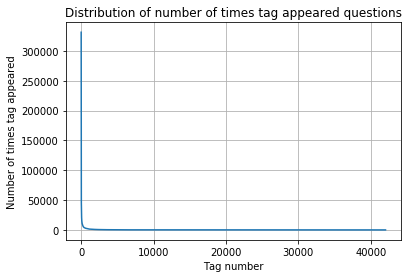

In [20]:
#Plotting the counts of the tags
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

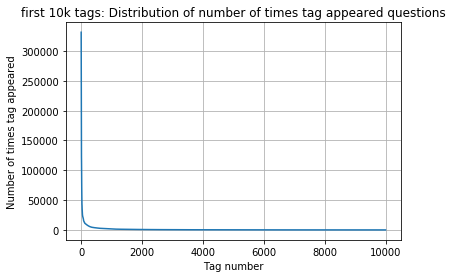

In [21]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

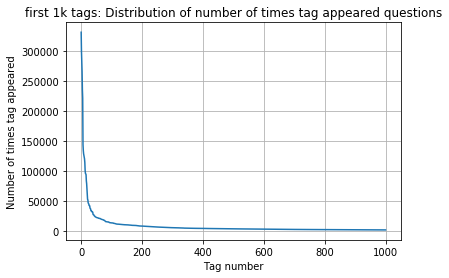

In [22]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

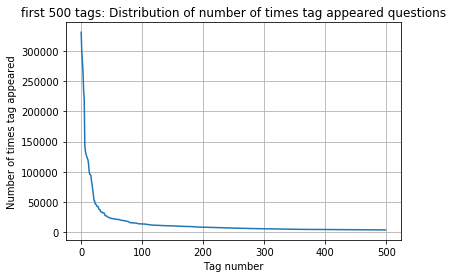

In [23]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

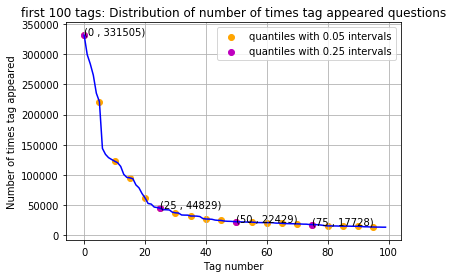

In [24]:
#For first 100 Tags (Quantile PLot)
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [25]:
tag_10k = tag_df[tag_df.Counts>10000].Tags
print ('{} Tags are used more than 10000 times'.format(len(tag_10k)))
tag_100k= tag_df[tag_df.Counts>100000].Tags
print ('{} Tags are used more than 100000 times'.format(len(tag_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


**Observation**

1) There are total 148 tags which are used more than 10000 times.

2) 14 tags are used more than 100000 times.

3) Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate     metric for this problem.

### Analysis of Tags per question

In [26]:
#Storing the count of tag in each question in list 'tag_count'
tag_per_questions = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_per_questions' to integer.
tag_per_questions =[int(j) for i in tag_per_questions for j in i]
print ('We have total {} datapoints.'.format(len(tag_per_questions)))
print(tag_per_questions[:5])

We have total 4206315 datapoints.
[1, 5, 1, 3, 3]


In [30]:
#Basic information
print( "Maximum number of tags per question: %d"%max(tag_per_questions))
print( "Minimum number of tags per question: %d"%min(tag_per_questions))
print( "Avg. number of tags per question: %f"% ((sum(tag_per_questions)*1.0)/len(tag_per_questions)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899439


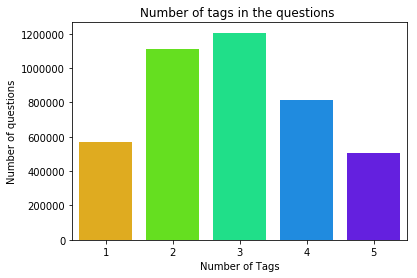

In [34]:
#Plotting the tag distribution (Histogram)
sns.countplot(tag_per_questions, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

 ### Most Frequent Tags

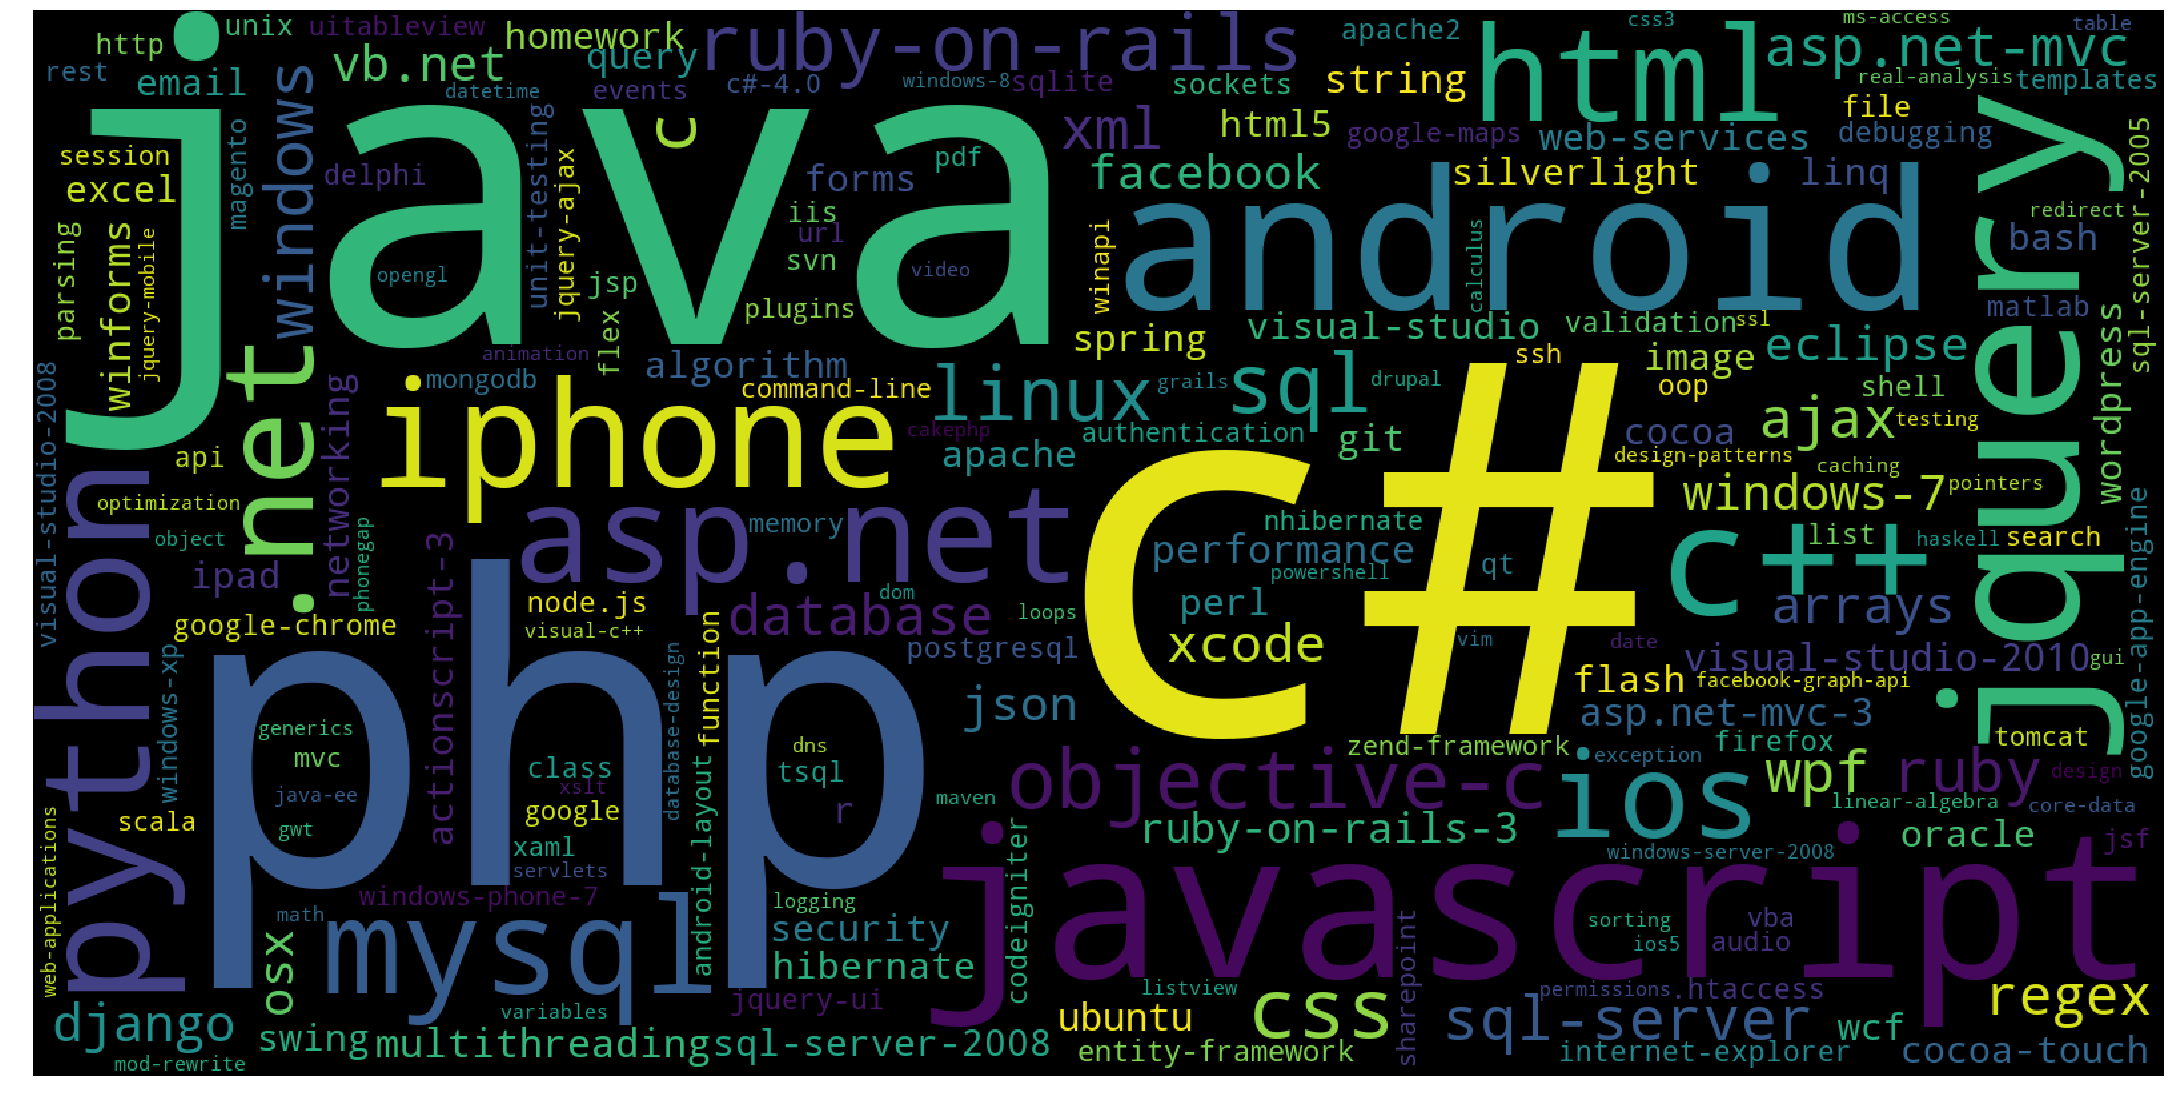

In [37]:
#Plotting a Word Cloud
# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='black',
                      width=1600,
                      height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

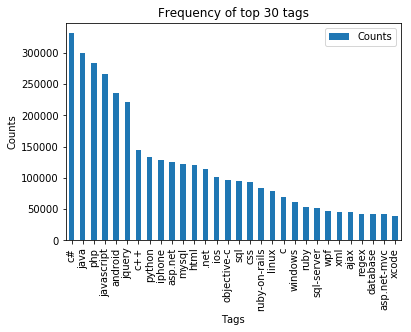

In [38]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

**Observations**:

1) Majority of the most frequent tags are programming language.

2) C# is the top most frequent programming language.

3) Android, IOS, Linux and windows are among the top most frequent operating systems.

### Text Cleaning and Preprocessing

In [40]:
#Function to clean html tags
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

#Function to clean punctuations
def clean_punc(data):
    return re.sub('[^a-zA-Z]',' ',data)

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [41]:
#Randomly Sampling few points
dataset_3=dataset_2.sample(frac=0.02, replace=False)

In [42]:
print('The size of the dataset is :',dataset_3.shape)
dataset_3.head(3)

The size of the dataset is : (84126, 4)


,Title,Body,Tags,Tag_Count
1559614,Good algorithm to check if post frequency is spam,<p>I have a site where a people can post text....,mysql algorithm frequency-analysis,3
4450911,Yii module actions url,<p>I have in my main project views/layouts/mai...,module yii action,3
3715732,WordPress register_nav_menu suddenly stopped w...,"<p>Ok, this is a biggie. Here's the deal:</p>\...",wordpress mamp,2


In [43]:
dataset_4=dataset_3.drop(['Tag_Count'],axis=1)
dataset_4.columns=('title','questions','tags')
dataset_4.head(3)

,title,questions,tags
1559614,Good algorithm to check if post frequency is spam,<p>I have a site where a people can post text....,mysql algorithm frequency-analysis
4450911,Yii module actions url,<p>I have in my main project views/layouts/mai...,module yii action
3715732,WordPress register_nav_menu suddenly stopped w...,"<p>Ok, this is a biggie. Here's the deal:</p>\...",wordpress mamp


In [45]:
# Cleaning process for the title and the questions/body (Give more weightage to the title)
preprocessed_data_list=[]
final_questions=[]
for index,row in dataset_4.iterrows():
    title, question, tags = row[0], row[1], row[2]
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    title=title.encode('utf-8')
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    question=clean_punc(question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    tup = (question,code,tags)
    preprocessed_data_list.append(tup)
    final_questions.append(question)

In [46]:
#Looking at cleaned Questions
print(final_questions[0:1])
print(final_questions[1:2])
print(final_questions[2:3])
print(final_questions[3:4])
print(final_questions[4:5])

['good algorithm check post frequenc spam good algorithm check post frequenc spam good algorithm check post frequenc spam site peopl post text post store databas ip poster time post want abl display recaptcha determin poster bot spammer etc good algorithm simplest choic analyz whether number post pre determin time period say one minut greater chosen limit say howev flaw fall multipl peopl post behind ip even bot creat random frequenc interv time period post less limit time period obvious correct answer algorithm better other howev tri find best one']
['yii modul action url yii modul action url yii modul action url main project view layout main php follow event modul action click erstellen modul action work perfect click verwalten afterward get error control action obvious add anoth front alreadi page event modul overcom problem']
['wordpress regist nav menu sudden stop work local wordpress regist nav menu sudden stop work local wordpress regist nav menu sudden stop work local ok biggi 

In [47]:
dataset_4['Questions']=final_questions
dataset_4['Questions']=dataset_4['Questions']

In [50]:
dataset_4.tail(5)

,title,questions,tags,Questions
1537907,get text from another file and include into an...,<p>I've found a function to spin text while br...,php,get text anoth file includ anoth function get ...
716737,startup script to check if external monitor is...,<p>My first question here; normally I can find...,python hardware detection,startup script check extern monitor attach sta...
3185155,How to delegate to default format provider?,<p>I'd like to create an <code>EscapingFormatP...,c# string-formatting,deleg default format provid deleg default form...
255203,create iptables rule per process/service,<p>is it possible to use iptables in order to ...,linux iptables,creat iptabl rule per process servic creat ipt...
2522134,Blackberry-10 Cascades,"<p>Am new to Blackberry-10 development,i am ru...",simulator blackberry-10,blackberri cascad blackberri cascad blackberri...


In [52]:
dataset_5=dataset_4.drop(['questions','title'],axis=1)
dataset_5.columns=('Tags','Questions')
dataset_5.head(10)

,Tags,Questions
1559614,mysql algorithm frequency-analysis,good algorithm check post frequenc spam good a...
4450911,module yii action,yii modul action url yii modul action url yii ...
3715732,wordpress mamp,wordpress regist nav menu sudden stop work loc...
273871,google-chrome-extensions xmarks,xmark chrome work xmark chrome work xmark chro...
3032274,c# winforms events mouse,visual c mous event panel fire visual c mous e...
1189759,c# .net winforms,c grid like interfac similar file explor delet...
612022,css cross-browser,css cross browser issu css cross browser issu ...
2256728,javascript magento prototypejs,javascript error page javascript error page ja...
13693,ruby-on-rails solr,solr sunspot max result solr sunspot max resul...
4423708,c++,variabl multi word input c variabl multi word ...


In [53]:
print("number of data points in sample :", dataset_5.shape[0])
print("number of dimensions :", dataset_5.shape[1])

number of data points in sample : 84126
number of dimensions : 2


### Converting tags for multilabel problems 

In [54]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split( ), binary='true')
multilabel_y = vectorizer.fit_transform(dataset_5['Tags'])

In [55]:
multilabel_y.shape

(84126, 17284)

#Choosing specific tags and questions accordingly (Partial Coverage)

**We will sample the number of tags instead considering all of them (due to limitation of computing power)**

In [56]:
#Choosing tags and Questions
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [58]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=dataset_5.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

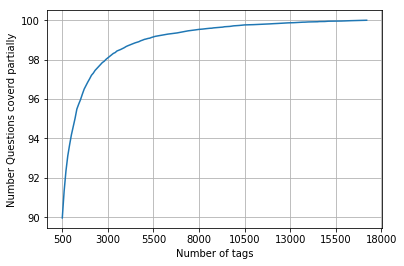

with  500 tags we are covering  91.319 % of questions


In [59]:
# Percentage of questions covered give number of tags plot
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Percentage of Questions coverd partially")
plt.grid()
plt.show()
print("with ",500,"tags we are covering ",questions_explained[1],"% of questions")

In [60]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 713 out of  84126


In [61]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 17284
number of tags taken : 500 ( 2.8928488775746355 %)


We consider top 3% tags which covers 92% of the questions

### Split the data into test and train

In [63]:
total_size=dataset_5.shape[0]
train_size=int(0.80*total_size)

x_train=dataset_5.head(train_size)
x_test=dataset_5.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [64]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (67300, 500)
Number of data points in test data : (16826, 500)


In [65]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['Questions'])
x_test_multilabel = vectorizer.transform(x_test['Questions'])

In [66]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (67300, 89050) Y : (67300, 500)
Dimensions of test data X: (16826, 89050) Y: (16826, 500)


In [ ]:
"""
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train_multilabel, y_train)

# predict
predictions = classifier.predict(x_test_multilabel)
print(accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test, predictions, average = 'macro'))
print(metrics.f1_score(y_test, predictions, average = 'micro'))
print(metrics.hamming_loss(y_test,predictions))

"""
# we are getting memory error because the multilearn package 
# is trying to convert the data into dense matrix
# ---------------------------------------------------------------------------
# MemoryError                               Traceback (most recent call last)
# <ipython-input-170-f0e7c7f3e0be> in <module>()
# ----> classifier.fit(x_train_multilabel, y_train)

### Applying Logistic Regression with OneVsRest Classifier (SGD VERSION)

In [67]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 score :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.23392368952811127
macro f1 score : 0.33987854996769745
micro f1 score : 0.478737184131375
hamming loss : 0.0028221799595863546
Precision recall report :
              precision    recall  f1-score   support

          0       0.62      0.25      0.36      1331
          1       0.78      0.45      0.57      1143
          2       0.88      0.59      0.70      1172
          3       0.75      0.44      0.56      1111
          4       0.96      0.74      0.83      1000
          5       0.87      0.64      0.74       873
          6       0.67      0.31      0.43       579
          7       0.89      0.64      0.75       541
          8       0.70      0.40      0.51       513
          9       0.89      0.61      0.72       521
         10       0.74      0.42      0.53       488
         11       0.55      0.22      0.32       506
         12       0.57      0.12      0.19       436
         13       0.65      0.28      0.39       417
         14       0.69      0.31     

###  Applying Logistic Regression with OneVsRest Classifier

In [68]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2314869844288601
Hamming loss  0.0028356115535480802
Micro-average quality numbers
Precision: 0.7136, Recall: 0.3579, F1-measure: 0.4767
Macro-average quality numbers
Precision: 0.5212, Recall: 0.2752, F1-measure: 0.3455
             precision    recall  f1-score   support

          0       0.62      0.23      0.34      1331
          1       0.78      0.43      0.56      1143
          2       0.88      0.58      0.70      1172
          3       0.76      0.42      0.54      1111
          4       0.96      0.72      0.83      1000
          5       0.86      0.64      0.73       873
          6       0.66      0.30      0.41       579
          7       0.89      0.64      0.75       541
          8       0.70      0.40      0.51       513
          9       0.89      0.61      0.72       521
         10       0.73      0.41      0.52       488
         11       0.56      0.21      0.31       506
         12       0.59      0.12      0.20       436
         13       0.65 

### Why not used advanced Models

1) Text featurized as TF-IDF vector leads to high dimensions where linear models (Logistic regression and Linear-SVM) perform better over tree based models hence choosed Logistic Regression

2) As we are following multi label classification we use binary relevance technique there by building 500 models for 500 tags which can get computationally very expensive with other methods